In [183]:
import os
import time
import pickle
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from catboost.utils import get_confusion_matrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import shap

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks'

In [3]:
shap.initjs()

In [11]:
random_seed = 123

print("start")

df_eco_pos = pd.read_csv('../../link_predict_kgmicrobe_shape_80/taxa_trait__subtract.tsv', sep=',',  encoding='utf-8')#index_col=1,
print(df_eco_pos.head())

start
                                          Unnamed: 0        X0        X1  \
0  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.206761 -0.119199   
1  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.187370 -0.193498   
2  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.196275 -0.164326   
3  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.215176 -0.124811   
4  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.149940 -0.117665   

         X2        X3        X4        X5        X6        X7        X8  ...  \
0  0.277861 -0.156555 -0.110481 -0.787591  0.033343 -0.184241  0.119956  ...   
1  0.267606 -0.229332 -0.131451 -0.820005  0.087749 -0.221265  0.070776  ...   
2  0.249419 -0.174717 -0.126318 -0.884014  0.070151 -0.277667  0.082363  ...   
3  0.322110 -0.223143 -0.128784 -0.866364  0.077432 -0.238856  0.093599  ...   
4  0.248190 -0.187161 -0.105828 -0.878060  0.049970 -0.199178  0.117177  ...   

        X54        X55       X56       X57       X58    

In [12]:
df_eco_neg = pd.read_csv('../../link_predict_kgmicrobe_shape_80/taxa_trait_NEGATIVE__subtract.tsv', sep=',',  encoding='utf-8')#index_col=1,
print(df_eco_neg.head())

                                          Unnamed: 0        X0        X1  \
0  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.162613 -0.174497   
1  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.174692 -0.177802   
2  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.195827 -0.122487   
3  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.160330 -0.287246   
4  microtraits.cell_shape_enum:bacillus__NCBITaxo...  0.193446 -0.155200   

         X2        X3        X4        X5        X6        X7        X8  ...  \
0  0.235394 -0.236301 -0.142398 -0.855280  0.062657 -0.272621  0.061759  ...   
1  0.265326 -0.217485 -0.109473 -0.796064  0.083513 -0.180881  0.032191  ...   
2  0.290897 -0.229242 -0.086972 -0.847015  0.055175 -0.198610  0.104823  ...   
3  0.222948  0.164843 -0.049281  0.341323  0.173327 -0.164237  0.214401  ...   
4  0.297539 -0.142336 -0.112967 -0.846508  0.048318 -0.194271  0.089820  ...   

        X54        X55       X56       X57       X58       X59

In [51]:
df_eco_total_train = df_eco_pos#pd.concat([df_eco_pos, df_eco_neg])

In [52]:
df_eco_total_train.head()

,Unnamed: 0,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63
0,microtraits.cell_shape_enum:bacillus__NCBITaxo...,0.206761,-0.119199,0.277861,-0.156555,-0.110481,-0.787591,0.033343,-0.184241,0.119956,...,0.283192,14.872420,-0.404251,0.035694,0.168451,0.252469,0.177430,0.492979,0.365547,0.346026
1,microtraits.cell_shape_enum:bacillus__NCBITaxo...,0.187370,-0.193498,0.267606,-0.229332,-0.131451,-0.820005,0.087749,-0.221265,0.070776,...,0.222907,14.827500,-0.348544,0.086878,0.153879,0.318783,0.174287,0.536081,0.270402,0.337462
2,microtraits.cell_shape_enum:bacillus__NCBITaxo...,0.196275,-0.164326,0.249419,-0.174717,-0.126318,-0.884014,0.070151,-0.277667,0.082363,...,0.277164,14.781036,-0.379275,0.003104,0.108615,0.265888,0.117289,0.521764,0.344082,0.360840
3,microtraits.cell_shape_enum:bacillus__NCBITaxo...,0.215176,-0.124811,0.322110,-0.223143,-0.128784,-0.866364,0.077432,-0.238856,0.093599,...,0.288985,14.815844,-0.379918,0.022896,0.157703,0.248542,0.116827,0.517681,0.298094,0.290743
4,microtraits.cell_shape_enum:bacillus__NCBITaxo...,0.149940,-0.117665,0.248190,-0.187161,-0.105828,-0.878060,0.049970,-0.199178,0.117177,...,0.281364,14.867459,-0.394944,0.068541,0.161027,0.321411,0.172431,0.470581,0.301429,0.348527


In [53]:
df_eco_total_train.index = df_eco_total_train['Unnamed: 0']
df_eco_total_train = df_eco_total_train.drop('Unnamed: 0', axis=1)

In [54]:
type(df_eco_total_train.index.to_numpy())

numpy.ndarray

In [55]:
pos_shape_ar_all = list(np.array(df_eco_total_train.index.to_numpy()))

In [56]:
#pos_shape_ar = np.char.split(pos_shape_ar_all, sep ='__')#.index.to_numpy().split("__")
pos_shape_ar_all_labels = [i.split('__', 1)[0] for i in pos_shape_ar_all]

In [20]:
#df_eco_total_train_pos_neg = [1] * df_eco_pos.shape[1]
#df_eco_total_train_pos_neg_2 = [0] * df_eco_neg.shape[1]

In [22]:
#df_eco_total_train_pos_neg = df_eco_total_train_pos_neg + df_eco_total_train_pos_neg_2

In [9]:
df_eco_test = pd.read_csv('../../link_predict_kgmicrobe_shape/kgmicrobe_test.txt', sep='\t',  encoding='utf-8')
print(df_eco_test.head())

                                                           X0        X1  \
microtraits.cell_shape_enum:bacillus__NCBITaxon...  -0.015209 -1.532297   
microtraits.cell_shape_enum:coccobacillus__NCBI...   0.317130 -1.302249   
microtraits.cell_shape_enum:coccus__NCBITaxon:2208 -15.981571  2.131460   
microtraits.cell_shape_enum:bacillus__NCBITaxon... -15.445293  0.026605   
microtraits.cell_shape_enum:coccus__NCBITaxon:2285 -15.988669  2.121459   

                                                          X2        X3  \
microtraits.cell_shape_enum:bacillus__NCBITaxon...  0.096468 -0.169220   
microtraits.cell_shape_enum:coccobacillus__NCBI... -0.139450  0.112107   
microtraits.cell_shape_enum:coccus__NCBITaxon:2208 -0.233341 -0.062597   
microtraits.cell_shape_enum:bacillus__NCBITaxon...  0.072540 -0.180230   
microtraits.cell_shape_enum:coccus__NCBITaxon:2285 -0.249583 -0.050713   

                                                          X4        X5  \
microtraits.cell_shape_enum:ba

In [59]:
df_eco_test_labels = list(df_eco_test.index.values)
df_eco_test_labels = [i.split('__', 1)[0] for i in df_eco_test_labels]
df_eco_test_labels

['microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:coccobacillus',
 'microtraits.cell_shape_enum:coccus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:coccus',
 'microtraits.cell_shape_enum:coccus',
 'microtraits.cell_shape_enum:coccus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:coccus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:coccus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_enum:coccus',
 'microtraits.cell_shape_enum:bacillus',
 'microtraits.cell_shape_

In [60]:
df_eco_total_train.shape

(18728, 64)

In [61]:
df_eco_total_train.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63
count,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,...,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000
mean,0.177229,-0.000400,0.266704,-0.120542,-0.147384,-0.773623,0.043882,-0.179227,-0.007960,-0.250909,...,0.167839,14.329040,-0.377651,0.070965,0.064967,0.198776,0.035120,0.346573,0.254794,0.275795
std,0.073113,0.211680,0.106304,0.123043,0.108891,0.234321,0.065678,0.142305,0.112805,0.196305,...,0.346355,3.058933,0.190684,0.182629,0.127057,0.169821,0.151726,0.214204,0.185519,0.140805
min,-0.930912,-1.066250,-1.869034,-1.065734,-1.726213,-2.395114,-1.395403,-1.524779,-1.617577,-1.893927,...,-2.269033,-14.528515,-2.995236,-1.314043,-1.149817,-1.240467,-1.690492,-1.097600,-1.987237,-0.924370
25%,0.145301,-0.168892,0.242900,-0.198998,-0.205436,-0.850455,0.009765,-0.249553,-0.116476,-0.397479,...,-0.028966,14.809721,-0.440456,0.022960,-0.072837,0.070971,-0.136241,0.208030,0.276044,0.272353
50%,0.174113,-0.124502,0.271708,-0.157074,-0.140334,-0.821446,0.038837,-0.219875,0.036547,-0.353412,...,0.219932,14.855436,-0.411131,0.067115,0.112315,0.255841,0.107029,0.453188,0.305667,0.300646
75%,0.203725,0.260424,0.300229,-0.052890,-0.095843,-0.793559,0.067251,-0.189997,0.079493,-0.082290,...,0.263755,15.187170,-0.367135,0.112809,0.153678,0.299506,0.148825,0.494966,0.335668,0.332248
max,1.160056,1.632384,1.648044,2.194661,1.096843,1.487012,1.248094,1.638029,0.821396,2.096799,...,2.618917,15.458015,2.399954,2.057181,1.183983,1.784052,1.475406,1.698233,1.282777,1.543522


In [99]:
type(ser.isin(keep_y))
#type(pos_shape_ar_all["X0"])
type(pos_shape_ar_all)
print(len(pos_shape_ar_all_labels))
print(df_eco_total_train.shape)
type(pos_shape_ar_all_labels)
type(ser.isin(keep_y))

18728
(18728, 64)


pandas.core.series.Series

In [111]:
ser = pd.Series(pos_shape_ar_all_labels)
ser.index = df_eco_total_train.index
y_counts = ser.value_counts()
#require minimum category members = 3
keep_y = y_counts[y_counts > 2].index
df_eco_total_train_trim = df_eco_total_train[ser.isin(keep_y)]
print(df_eco_total_train_trim.shape)

print(type(pos_shape_ar_all_labels))
print(len(list(ser.isin(keep_y))))
#print(len(list(ser.isin(keep_y)) == True))
print(type(ser.isin(keep_y)))

pos_shape_ar_all_labels_trim = ser[ser.isin(keep_y)]
print(len(pos_shape_ar_all_labels_trim))

(18721, 64)
<class 'list'>
18728
<class 'pandas.core.series.Series'>
18721


In [114]:
y = pos_shape_ar_all_labels_trim
print(y)


X = df_eco_total_train_trim

Unnamed: 0
microtraits.cell_shape_enum:bacillus__NCBITaxon:54261     microtraits.cell_shape_enum:bacillus
microtraits.cell_shape_enum:bacillus__NCBITaxon:2714      microtraits.cell_shape_enum:bacillus
microtraits.cell_shape_enum:bacillus__NCBITaxon:29466     microtraits.cell_shape_enum:bacillus
microtraits.cell_shape_enum:bacillus__NCBITaxon:266       microtraits.cell_shape_enum:bacillus
microtraits.cell_shape_enum:bacillus__NCBITaxon:36861     microtraits.cell_shape_enum:bacillus
                                                                          ...                 
microtraits.cell_shape_enum:coccus__NCBITaxon:553204        microtraits.cell_shape_enum:coccus
microtraits.cell_shape_enum:coccus__NCBITaxon:592010        microtraits.cell_shape_enum:coccus
microtraits.cell_shape_enum:disc __NCBITaxon:887324          microtraits.cell_shape_enum:disc 
microtraits.cell_shape_enum:coccus__NCBITaxon:575587        microtraits.cell_shape_enum:coccus
microtraits.cell_shape_enum:bacillus__N

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_seed) #, random_state=9# The seed was 'chosen' so test and training contain all labels: rn=3,4,8,9
print("train label deficit:",len(set(y)-set(y_train)),"test label deficit:",len(set(y)-set(y_test)))

print("shapes "+str(X_train.shape)+"\t"+str(X_test.shape)+"\t"+str(y_train.shape)+"\t"+str(y_test.shape))

train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

input_data_dump = [X, y, X_train, X_test, y_train, y_test]
pickle.dump(input_data_dump,open("input_data_dump", "wb" ) )

train label deficit: 0 test label deficit: 0
shapes (14040, 64)	(4681, 64)	(14040,)	(4681,)


In [116]:

class_counts = y_train.value_counts()
max_count = max(class_counts)
class_weights = {i:max_count/x for i,x in class_counts.iteritems()}
class_weights

{'microtraits.cell_shape_enum:bacillus': 1.0,
 'microtraits.cell_shape_enum:coccus': 1.9603673272112132,
 'microtraits.cell_shape_enum:spiral': 13.843003412969283,
 'microtraits.cell_shape_enum:coccobacillus': 21.125,
 'microtraits.cell_shape_enum:vibrio': 21.291338582677167,
 'microtraits.cell_shape_enum:filament': 22.722689075630253,
 'microtraits.cell_shape_enum:pleomorphic': 197.85365853658536,
 'microtraits.cell_shape_enum:disc ': 624.0,
 'microtraits.cell_shape_enum:fusiform': 737.4545454545455,
 'microtraits.cell_shape_enum:square': 2028.0,
 'microtraits.cell_shape_enum:flask': 2028.0,
 'microtraits.cell_shape_enum:irregular': 2028.0,
 'microtraits.cell_shape_enum:star': 2704.0,
 'microtraits.cell_shape_enum:branced': 4056.0}

In [117]:
iseed = 123

cb_model = CatBoostClassifier(
    iterations=200,
    verbose=5,
    learning_rate=0.02,
    depth=5,
    eval_metric='MCC',
    random_seed=iseed,
    bagging_temperature=0.2,
    od_type='Iter',
    od_wait=100,
    class_weights=class_weights)

grid = {'learning_rate': [0.06, 0.1,0.14],
        'depth': [4, 5, 6],
        'l2_leaf_reg': [0.5, 1, 5]}

In [118]:
modelstart = time.time()
print(f"Starting model parameter optimization at {modelstart}")

grid_search_result = cb_model.grid_search(grid, X=X_train, y=y_train,verbose=5)
lr = grid_search_result['params']['learning_rate']
de = grid_search_result['params']['depth']
l2 = grid_search_result['params']['l2_leaf_reg']

print(f"Finished in {time.time() - modelstart}s")

print("lr "+str(lr)+" de "+str(de)+" l2 "+str(l2))

Starting model parameter optimization at 1617755369.331959
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1
bestIteration = 87

0:	loss: 1.0000000	best: 1.0000000 (0)	total: 4.44s	remaining: 1m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9216494454
bestIteration = 79


bestTest = 0.9216494454
bestIteration = 99

Stopped by overfitting detector  (100 iterations wait)

bestTest = 1
bestIteration = 93

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9216075791
bestIteration = 71

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9216075791
bestIteration = 94

5:	loss: 0.9216076	best: 1.0000000 (0)	total: 30s	remaining: 1m 45s

bestTest = 1
bestIteration = 164


bestTest = 0.9999583011
bestIteration = 106


bestTest = 0.9216494454
bestIteration = 114


bestTest = 0.8938943337
bestIteration = 157


bestTest = 0.9224819287
bestIteration = 164

10:	loss: 0.9224819	best: 1.0000000 (0)	total: 1m 6s	remainin

Stopped by overfitting detector  (100 iterations wait)
Finished in 339.9862320423126s
lr 0.06 de 4 l2 0.5


In [119]:
#lr=0.5
#de=7
#l2=1
cb_model = CatBoostClassifier(
    iterations=200,
    verbose=5,
    learning_rate=lr,
    depth=de,
    l2_leaf_reg=l2,
    eval_metric='MCC',
    random_seed = iseed,
    bagging_temperature = 0.2,
    od_type='Iter',
    od_wait=100,
    class_weights=class_weights,
)

In [120]:
modelstart = time.time()
print(f"Starting training at {modelstart}")
cbmpf = cb_model.fit(X_train, y_train);
print(f"Training finished in {time.time() - modelstart}s")

Starting training at 1617755765.445159
0:	learn: 0.3585633	total: 47.7ms	remaining: 9.49s
5:	learn: 0.7511212	total: 168ms	remaining: 5.42s
10:	learn: 0.9403994	total: 291ms	remaining: 4.99s
15:	learn: 0.9463631	total: 405ms	remaining: 4.66s
20:	learn: 0.9538918	total: 529ms	remaining: 4.51s
25:	learn: 0.9630960	total: 649ms	remaining: 4.34s
30:	learn: 0.9741614	total: 776ms	remaining: 4.23s
35:	learn: 0.9870727	total: 901ms	remaining: 4.11s
40:	learn: 0.9999533	total: 1.03s	remaining: 3.99s
45:	learn: 0.9999719	total: 1.16s	remaining: 3.87s
50:	learn: 0.9999719	total: 1.29s	remaining: 3.76s
55:	learn: 0.9999719	total: 1.41s	remaining: 3.63s
60:	learn: 0.9999905	total: 1.54s	remaining: 3.52s
65:	learn: 1.0000000	total: 1.67s	remaining: 3.4s
70:	learn: 1.0000000	total: 1.79s	remaining: 3.26s
75:	learn: 1.0000000	total: 1.92s	remaining: 3.13s
80:	learn: 1.0000000	total: 2.04s	remaining: 2.99s
85:	learn: 1.0000000	total: 2.16s	remaining: 2.86s
90:	learn: 1.0000000	total: 2.32s	remaining: 

In [121]:
predictions = cbmpf.predict(X_test)
predictions_probs = cbmpf.predict_proba(X_test)
cbmpf = cb_model.fit(X_train, y_train)

0:	learn: 0.3585633	total: 42.1ms	remaining: 8.37s
5:	learn: 0.7511212	total: 162ms	remaining: 5.24s
10:	learn: 0.9403994	total: 284ms	remaining: 4.88s
15:	learn: 0.9463631	total: 408ms	remaining: 4.69s
20:	learn: 0.9538918	total: 533ms	remaining: 4.55s
25:	learn: 0.9630960	total: 656ms	remaining: 4.39s
30:	learn: 0.9741614	total: 788ms	remaining: 4.29s
35:	learn: 0.9870727	total: 914ms	remaining: 4.16s
40:	learn: 0.9999533	total: 1.04s	remaining: 4.03s
45:	learn: 0.9999719	total: 1.17s	remaining: 3.92s
50:	learn: 0.9999719	total: 1.3s	remaining: 3.81s
55:	learn: 0.9999719	total: 1.43s	remaining: 3.67s
60:	learn: 0.9999905	total: 1.56s	remaining: 3.55s
65:	learn: 1.0000000	total: 1.68s	remaining: 3.41s
70:	learn: 1.0000000	total: 1.83s	remaining: 3.33s
75:	learn: 1.0000000	total: 2s	remaining: 3.26s
80:	learn: 1.0000000	total: 2.13s	remaining: 3.12s
85:	learn: 1.0000000	total: 2.25s	remaining: 2.98s
90:	learn: 1.0000000	total: 2.38s	remaining: 2.86s
95:	learn: 1.0000000	total: 2.52s	re

In [123]:
explainer_model = shap.TreeExplainer(cb_model)

In [145]:
type(cb_model.feature_names_)

list

In [146]:
model_feature_importance = pd.Series(data=cb_model.feature_importances_, index=cb_model.feature_names_)
model_feature_importance

X0     1.056782
X1     1.627523
X2     2.230934
X3     2.397574
X4     1.372739
         ...   
X59    1.006378
X60    1.601660
X61    0.607963
X62    0.098870
X63    1.054834
Length: 64, dtype: float64

X62    0.098870
X40    0.099861
X20    0.214741
X25    0.257512
X49    0.315891
         ...   
X48    3.524798
X50    3.623415
X37    3.687950
X47    4.383784
X6     5.241683
Length: 64, dtype: float64


Text(0.5, 0, 'CatBoost Feature Importance')

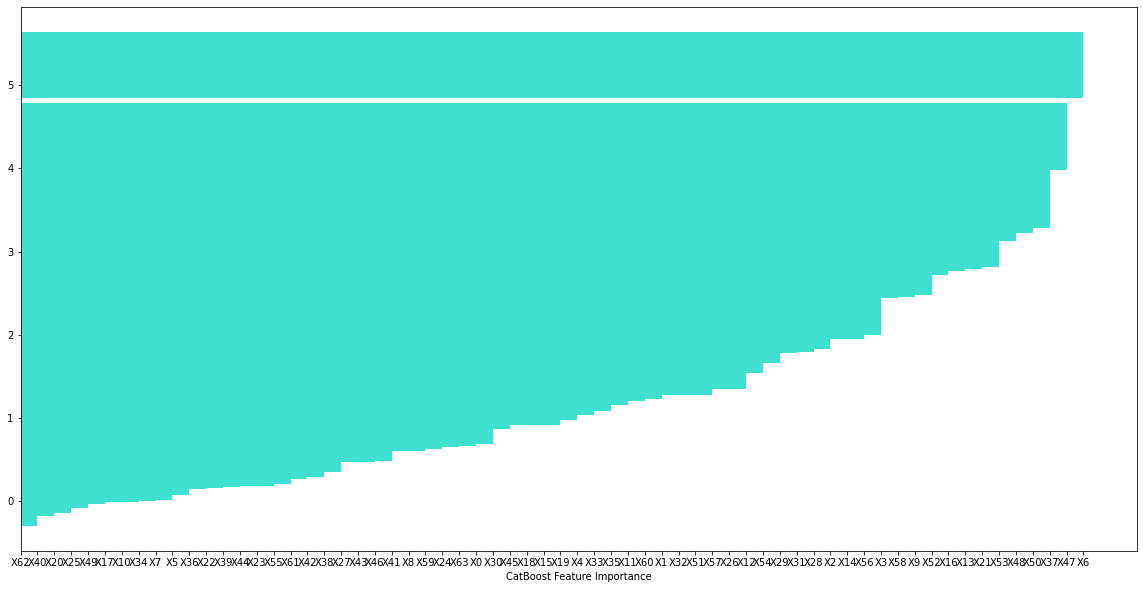

In [147]:
sorted_feature_importance = model_feature_importance[model_feature_importance.argsort()]
print(sorted_feature_importance)
plt.figure(figsize=(20,10))
plt.barh(sorted_feature_importance.values,
        sorted_feature_importance.index,
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [171]:
#confusion_matrix = get_confusion_matrix(cb_model, Pool(X_train, y_train))
confusion_matrix_test = get_confusion_matrix(cb_model, Pool(X_test, y_test))
print(confusion_matrix_test.shape)
print(len(cb_model.classes_))
confusion_matrix_test_pd = pd.DataFrame(data=np.log(confusion_matrix_test+0.001), columns=cb_model.classes_, index=cb_model.classes_)

(14, 14)
14


In [179]:
precision_recall_fscore_support(y_test, predictions, average=None)

(array([1. , 0. , 1. , 1. , 0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. ]),
 array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1.        , 0.        , 1.        , 1.        , 0.88888889,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 array([2704,    1,  128, 1379,    4,  119,    1,    4,    2,   14,  195,
           2,    1,  127]))

In [175]:
precision_recall_fscore_support(y_test, predictions, average='macro')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


(0.9142857142857144, 0.9285714285714286, 0.9206349206349207, None)

In [176]:
precision_recall_fscore_support(y_test, predictions, average='micro')

(0.999786370433668, 0.999786370433668, 0.999786370433668, None)

In [177]:
precision_recall_fscore_support(y_test, predictions, average='weighted')

(0.9996154667806024, 0.999786370433668, 0.9996914239597428, None)

In [181]:
precision_recall_fscore_support(y_test, predictions, average=None, labels=cb_model.classes_)

(array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.8, 1. , 1. , 1. , 1. , 1. ,
        0. ]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.88888889, 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.        ]),
 array([2704, 1379,  195,  128,  127,  119,   14,    4,    4,    2,    1,
           2,    1,    1]))

In [184]:
print(classification_report(y_test, predictions, target_names=cb_model.classes_))

                                           precision    recall  f1-score   support

     microtraits.cell_shape_enum:bacillus       1.00      1.00      1.00      2704
       microtraits.cell_shape_enum:coccus       0.00      0.00      0.00         1
       microtraits.cell_shape_enum:spiral       1.00      1.00      1.00       128
microtraits.cell_shape_enum:coccobacillus       1.00      1.00      1.00      1379
       microtraits.cell_shape_enum:vibrio       0.80      1.00      0.89         4
     microtraits.cell_shape_enum:filament       1.00      1.00      1.00       119
  microtraits.cell_shape_enum:pleomorphic       1.00      1.00      1.00         1
        microtraits.cell_shape_enum:disc        1.00      1.00      1.00         4
     microtraits.cell_shape_enum:fusiform       1.00      1.00      1.00         2
       microtraits.cell_shape_enum:square       1.00      1.00      1.00        14
        microtraits.cell_shape_enum:flask       1.00      1.00      1.00       195
   

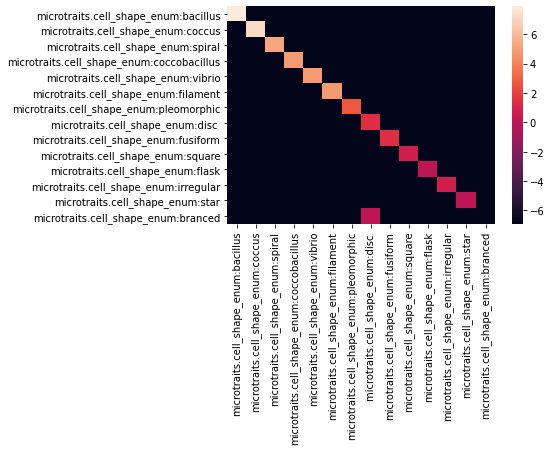

In [173]:
ax = sns.heatmap(confusion_matrix_test_pd)


In [150]:
shap_values = explainer_model.shap_values(X_test)

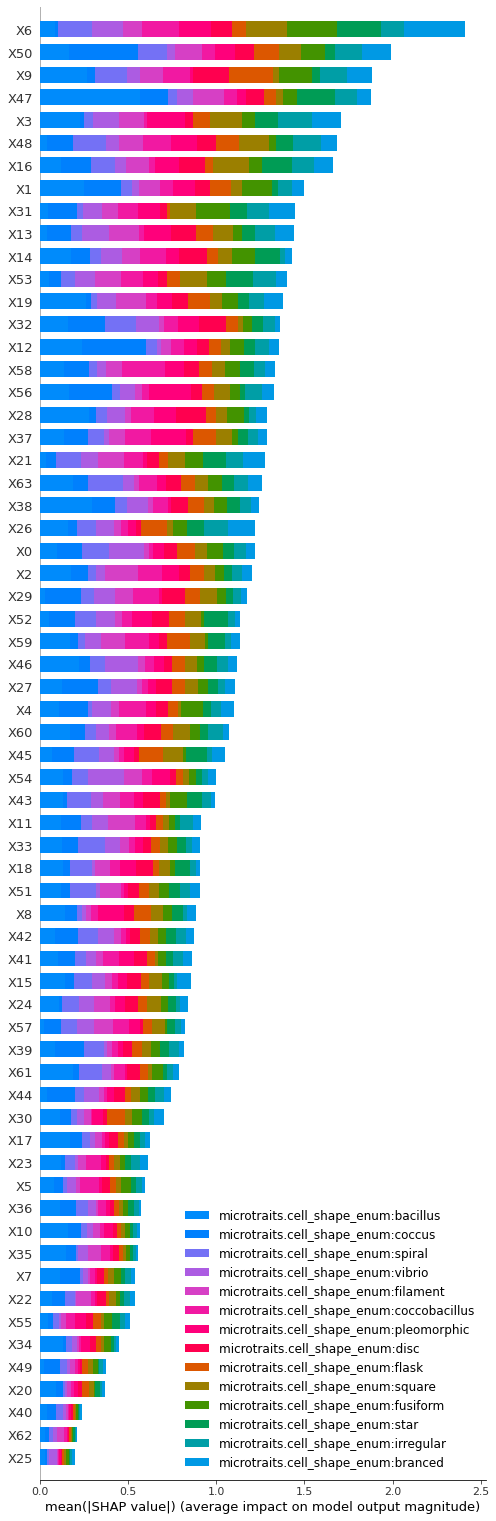

In [170]:
shap.summary_plot(shap_values, X_test, feature_names = cb_model.feature_names_,class_names=cb_model.classes_,max_display=X_test.shape[1])